In [1]:
import os
import networkx as nx
import numpy as np
import math
import pandas as pd
import torch 
import torch.nn as nn

import matplotlib
matplotlib.use('agg')

from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import matplotlib.colors as colors



import gengraph
import configs
import featgen
import utils

In [2]:
input_dim = 4

G, labels, name = gengraph.gen_syn6(feature_generator=featgen.ConstFeatureGen(np.ones(input_dim, dtype=float)))

In [3]:
def label_to_temporal_label(label, time):
    if label == 0:
        return 0
    elif label == 1:
        return 0
    elif label == 2:
        if time % 4 == 0:
            return 1
        else:
            return 0
    else:
        if time % 4 == 2:
            return 1
        else:
            return 0

def gen_gt(columns, no_rows):
    gt = np.zeros((no_rows,len(columns)))
    for r in range(no_rows):
        for c in range(len(columns)):
            gt[r,c] = label_to_temporal_label(columns[c], r)
    return gt

In [4]:
no_snapshots = 100

gt = gen_gt(labels, no_snapshots)
data = pd.DataFrame(data=gt)
adj = nx.adjacency_matrix(G).todense()

In [5]:
def shift_pos(ori_pos, offset):
    new_pos = {}
    for key in ori_pos.keys():
        lag = key.split("lag",1)[1]
        new_key = key
        new_key = new_key.split("lag",1)[0] + 'lag' + str(int(lag)+1)
        new_pos[new_key] = ori_pos[key].copy()
        new_pos[new_key][0] = new_pos[new_key][0] + offset
    return new_pos

def n_hops_A(base_adj, n_hops = 1):
    # Compute the n-hops adjacency matrix
    adj = torch.tensor(base_adj, dtype=torch.float)
    hop_adj = power_adj = adj
    for i in range(n_hops - 1):
        power_adj = power_adj @ adj
        prev_hop_adj = hop_adj
        hop_adj = hop_adj + power_adj
        hop_adj = (hop_adj > 0).float()
    return hop_adj.numpy().astype(int)

def extract_n_hops_neighbors(base_adj, node_idx, n_hops = 1):
    # Return the n-hops neighbors of a node
    hops_adj = n_hops_A(base_adj, n_hops)
    target_row = hops_adj[node_idx]
    neighbors = np.nonzero(target_row)[0]
    node_idx_new = sum(target_row[:node_idx])
    sub_A = base_adj[neighbors][:, neighbors]

    return node_idx_new, sub_A, neighbors

In [6]:
target = 600
node_idx_new, sub_A, neighbors = extract_n_hops_neighbors(adj, target, n_hops = 2)

In [7]:
print("Draw subgraph using networkx")

def graph_from_adj(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    return gr

plot_G = graph_from_adj(sub_A)
label_dict = dict(zip(range(len(neighbors.tolist())),neighbors.tolist()))

sub_pos=nx.spring_layout(plot_G)

nx.draw(plot_G, pos=sub_pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

Draw subgraph using networkx


In [8]:
from causalnex.structure.dynotears import from_numpy_dynamic, from_pandas_dynamic

In [9]:
lag_params = 2

sm_d =  from_pandas_dynamic(data[list(neighbors)], p = lag_params)
dbn = sm_d.copy()

In [10]:
fig_size = 8
offset = 3
cut_off = 0.001

base_edges = []
for src in neighbors:
    for dst in neighbors:
        if src < dst:
            if adj[src,dst] == 1:
                base_edges.append((str(src)+"_lag0",str(dst)+"_lag0"))

variables = {}
for i in range(lag_params + 1):
    variables[i] = [node for node in list(dbn.nodes) if node.endswith(str(i))]
variable_names = [node[:-5] for node in variables[0]]

intra_subgraphs = {}
for i in range(lag_params + 1):
    intra_subgraphs[i] = dbn.subgraph(variables[i])

base_subgraph = nx.DiGraph()
base_subgraph.add_nodes_from(intra_subgraphs[0].nodes())
base_subgraph.add_edges_from(base_edges)
# base_pos = nx.kamada_kawai_layout(base_subgraph)

base_pos = nx.spring_layout(intra_subgraphs[0].nodes())
# base_pos = nx.kamada_kawai_layout(intra_subgraphs[0])
# base_pos = dict(zip(list(intra_subgraphs[0].nodes()), sub_pos.values()))

current_pos = base_pos.copy()
pos = base_pos.copy()
for i in range(1, lag_params + 1):
    new_pos = shift_pos(current_pos, -offset)
    pos.update(new_pos)
    current_pos = new_pos

label_dict = dict(zip(variables[0], variable_names))
for i in range(lag_params+1):
    new_dict = dict(zip(variables[i], variable_names))
    label_dict.update(new_dict)

fig_width = fig_size*(lag_params + 1) + offset*lag_params
fig_height = fig_size

plt.figure(figsize = (fig_width, fig_height))

plot_g = dbn.copy()

drop_edges = [(u,v) for u,v,e in dbn.edges(data=True) if e['weight'] < cut_off and e['weight'] > - cut_off]
edge_weight = {(u, v):abs(e['weight']) for u,v,e in plot_g.edges(data=True)}

for e in drop_edges:
    plot_g.remove_edge(e[0],e[1])

nx.draw_networkx_edges(plot_g, pos=pos, edgelist = base_edges,
        alpha = 0.2,
        width = 4,
        arrows = False,
        edge_color = 'gray')
    
nx.draw(plot_g, pos=pos, 
        node_size=700, 
        labels=label_dict,
        font_size=12,
        node_color='gray',
        with_labels=True, 
        width = 2, 
        edge_color=[edge_weight[e] for e in plot_g.edges()],
        edge_cmap= plt.cm.Blues,
        connectionstyle="arc3,rad=-0.05",
        style = ':')

In [11]:
import seaborn as sns

for i in range(lag_params + 1):
    plot_adj = np.zeros((len(variable_names),len(variable_names))) 
    for irow in range(len(variables[0])):
        for icol in range(len(variables[i])):
            if dbn.get_edge_data(variables[i][irow],variables[0][icol]) != None:
                plot_adj[irow,icol] = dbn.get_edge_data(variables[i][irow],variables[0][icol])['weight']
            elif dbn.get_edge_data(variables[0][irow],variables[i][icol]) != None:
                plot_adj[irow,icol] = dbn.get_edge_data(variables[0][irow],variables[i][icol])['weight']
            else:
                plot_adj[irow,icol] = 0
    plt.figure(figsize = (6,5))
    ax = sns.heatmap(plot_adj, linewidth=0.5, vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

In [12]:
def generate_dataset(
    data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=False
):
    """
    :param data: feature matrix
    :param seq_len: length of the train data sequence
    :param pre_len: length of the prediction data sequence
    :param time_len: length of the time series in total
    :param split_ratio: proportion of the training set
    :param normalize: scale the data to (0, 1], divide by the maximum value in the data
    :return: train set (X, Y) and test set (X, Y)
    """
    if time_len is None:
        time_len = data.shape[0]
    if normalize:
        max_val = np.max(data)
        data = data / max_val

    train_size = int(time_len * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:time_len]
    train_X, train_Y, test_X, test_Y = list(), list(), list(), list()
    for i in range(len(train_data) - seq_len - pre_len):
        train_X.append(np.array(train_data[i : i + seq_len]))
        train_Y.append(np.array(train_data[i + seq_len : i + seq_len + pre_len]))
    for i in range(len(test_data) - seq_len - pre_len):
        test_X.append(np.array(test_data[i : i + seq_len]))
        test_Y.append(np.array(test_data[i + seq_len : i + seq_len + pre_len]))
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)


def generate_torch_datasets(
    data, seq_len, pre_len, time_len=None, split_ratio=0.8, normalize=False
):
    train_X, train_Y, test_X, test_Y = generate_dataset(
        data,
        seq_len,
        pre_len,
        time_len=time_len,
        split_ratio=split_ratio,
        normalize=normalize,
    )
    train_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(train_X), torch.FloatTensor(train_Y)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(test_X), torch.FloatTensor(test_Y)
    )
    return train_dataset, test_dataset

In [13]:
from torch.utils.data.dataloader import DataLoader
seq_len = 12
train_dataset, test_dataset = generate_torch_datasets(data, seq_len, 1)
batch_size = 20
train_dataloader  = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size)


In [14]:
import tgcn

hidden_dim = 10

model = tgcn.TGCN(adj=adj, hidden_dim=hidden_dim)
model

model.train()
loss = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

no_epoch = 100

losses = []

for epoch in range(no_epoch):
    epoch_loss = 0
    for X, y in train_dataloader:
        preds = model(X)
        l = loss(preds[:,:,0], y[:,0,:])
        epoch_loss = epoch_loss + l.item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        losses.append(epoch_loss)
    if epoch % 10 == 0:
        print("Epoch loss: ", epoch_loss)

Epoch loss:  0.7025096267461777
Epoch loss:  0.3613660857081413
Epoch loss:  0.21862747892737389
Epoch loss:  0.1588759645819664
Epoch loss:  0.09988243505358696
Epoch loss:  0.0587319191545248
Epoch loss:  0.02248289017006755
Epoch loss:  0.014220314100384712
Epoch loss:  0.011378508061170578
Epoch loss:  0.009687403915449977


In [15]:
model.eval()

preds_list = []
ys_list = []
current_inputs_list = []
for X, y in test_dataloader:
    test_loss = 0
    for X, y in train_dataloader:
        preds = model(X)
        l = loss(preds[:,:,0], y[:,0,:])
        test_loss = test_loss + l.item()
        
        preds_np = preds.detach().numpy()
        preds_list.append(preds_np)
        ys_list.append(y.detach().numpy()[:,0,:])
        current_inputs_list.append(X.detach().numpy()[:,-1,:])
print(test_loss)

0.00856181769631803


In [16]:
preds_array = np.vstack(preds_list)[:,:,0]
input_array = np.vstack(current_inputs_list)
ys_array = np.vstack(ys_list)

inputs_pd = pd.DataFrame(data=input_array)
preds_pd = pd.DataFrame(data=preds_array)
ys_pd = pd.DataFrame(data=ys_array)

In [17]:
lag_params = 2

sm_d_preds =  from_pandas_dynamic(preds_pd[list(neighbors)], p = lag_params)
dbn_preds = sm_d_preds.copy()

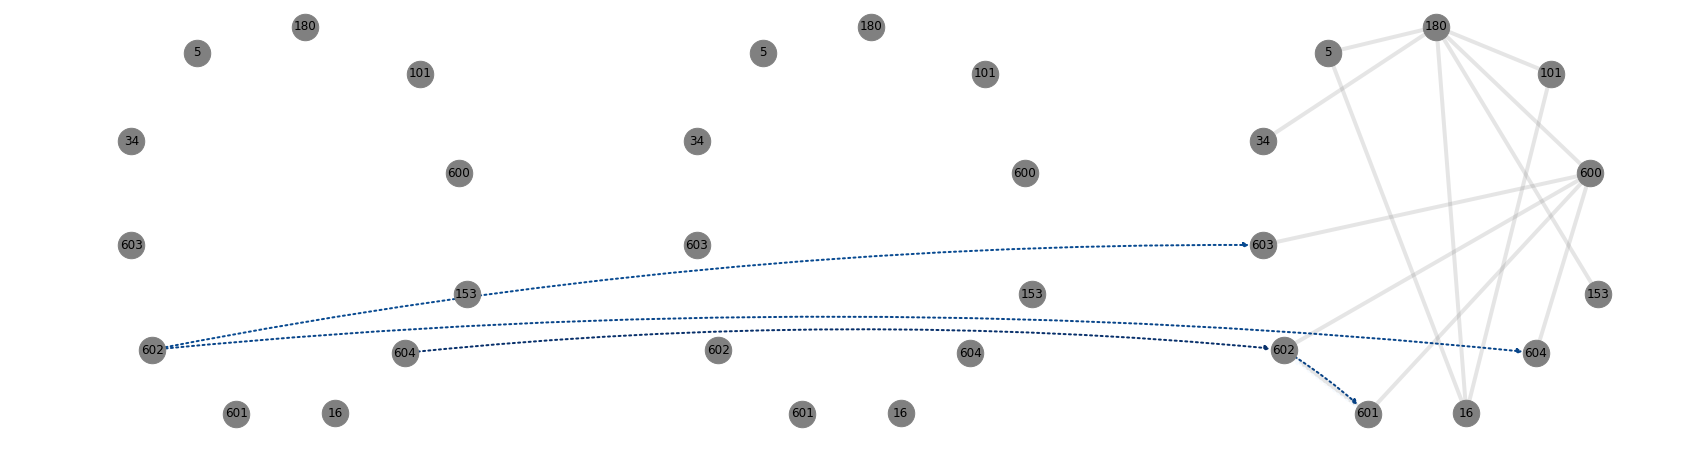

In [20]:
%matplotlib inline

fig_size = 8
offset = 3
cut_off = 0.0

base_edges = []
for src in neighbors:
    for dst in neighbors:
        if src < dst:
            if adj[src,dst] == 1:
                base_edges.append((str(src)+"_lag0",str(dst)+"_lag0"))

variables = {}
for i in range(lag_params + 1):
    variables[i] = [node for node in list(dbn_preds.nodes) if node.endswith(str(i))]
variable_names = [node[:-5] for node in variables[0]]

intra_subgraphs = {}
for i in range(lag_params + 1):
    intra_subgraphs[i] = dbn_preds.subgraph(variables[i])

base_subgraph = nx.DiGraph()
base_subgraph.add_nodes_from(intra_subgraphs[0].nodes())
base_subgraph.add_edges_from(base_edges)
# base_pos = nx.kamada_kawai_layout(base_subgraph)

base_pos = nx.spring_layout(intra_subgraphs[0].nodes())
# base_pos = nx.kamada_kawai_layout(intra_subgraphs[0])
# base_pos = dict(zip(list(intra_subgraphs[0].nodes()), sub_pos.values()))

current_pos = base_pos.copy()
pos = base_pos.copy()
for i in range(1, lag_params + 1):
    new_pos = shift_pos(current_pos, -offset)
    pos.update(new_pos)
    current_pos = new_pos

label_dict = dict(zip(variables[0], variable_names))
for i in range(lag_params+1):
    new_dict = dict(zip(variables[i], variable_names))
    label_dict.update(new_dict)

fig_width = fig_size*(lag_params + 1) + offset*lag_params
fig_height = fig_size

plt.figure(figsize = (fig_width, fig_height))

plot_g = dbn_preds.copy()

drop_edges = [(u,v) for u,v,e in dbn_preds.edges(data=True) if e['weight'] < cut_off and e['weight'] > - cut_off]
edge_weight = {(u, v):abs(e['weight']) for u,v,e in plot_g.edges(data=True)}

for e in drop_edges:
    plot_g.remove_edge(e[0],e[1])

nx.draw_networkx_edges(plot_g, pos=pos, edgelist = base_edges,
        alpha = 0.2,
        width = 4,
        arrows = False,
        edge_color = 'gray')
    
nx.draw(plot_g, pos=pos, 
        node_size=700, 
        labels=label_dict,
        font_size=12,
        node_color='gray',
        with_labels=True, 
        width = 2, 
        edge_color=[edge_weight[e] for e in plot_g.edges()],
        edge_cmap= plt.cm.Blues,
        connectionstyle="arc3,rad=-0.05",
        style = ':')

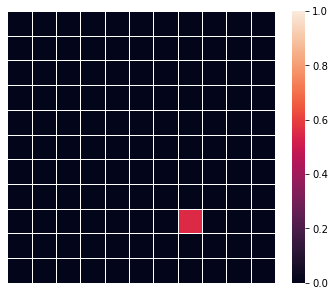

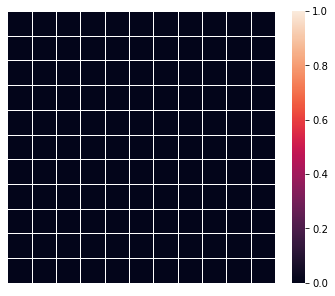

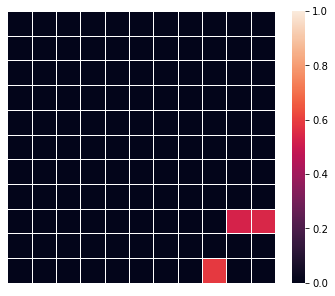

In [21]:
for i in range(lag_params + 1):
    plot_adj = np.zeros((len(variable_names),len(variable_names))) 
    for irow in range(len(variables[0])):
        for icol in range(len(variables[i])):
            if dbn_preds.get_edge_data(variables[i][irow],variables[0][icol]) != None:
                plot_adj[irow,icol] = dbn_preds.get_edge_data(variables[i][irow],variables[0][icol])['weight']
            elif dbn_preds.get_edge_data(variables[0][irow],variables[i][icol]) != None:
                plot_adj[irow,icol] = dbn_preds.get_edge_data(variables[0][irow],variables[i][icol])['weight']
            else:
                plot_adj[irow,icol] = 0
    plt.figure(figsize = (6,5))
    ax = sns.heatmap(plot_adj, linewidth=0.5, vmin=0, vmax=1)
    plt.axis('off')
    plt.show()

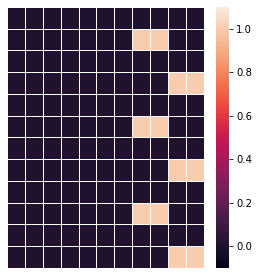

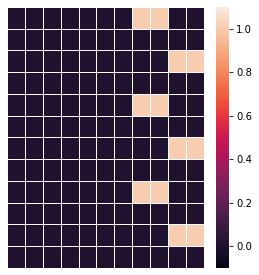

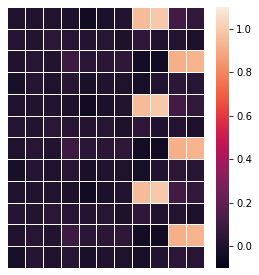

In [23]:
norm_size = 0.4

plt.figure(figsize = (norm_size * len(neighbors), norm_size * seq_len))
ax = sns.heatmap(inputs_pd[list(neighbors)].iloc[0:seq_len], linewidth=0.5, vmin=-0.1, vmax=1.1)
plt.axis('off')
plt.show()

plt.figure(figsize = (norm_size * len(neighbors), norm_size * seq_len))
ax = sns.heatmap(ys_pd[list(neighbors)].iloc[0:seq_len], linewidth=0.5, vmin=-0.1, vmax=1.1)
plt.axis('off')
plt.show()

plt.figure(figsize = (norm_size * len(neighbors), norm_size * seq_len))
ax = sns.heatmap(preds_pd[list(neighbors)].iloc[0:seq_len], linewidth=0.5, vmin=-0.1, vmax=1.1)
plt.axis('off')
plt.show()

In [38]:
start_index = 0
offset = 1

X_probe = inputs_pd.iloc[start_index + offset: start_index + offset + seq_len]
y_probe = model(torch.tensor(X_probe.values).unsqueeze(0))
base_pred = y_probe.detach().numpy()[0,:,0][target+1]
print(base_pred)
probe_matrix = np.zeros_like(X_probe[list(neighbors)])
for time_lag in range(seq_len):
    nei_index = 0
    for nei in neighbors:
        X_per = X_probe.copy()
        X_per[nei].iloc[time_lag] = 0.25
        y_probe = model(torch.tensor(X_per.values).unsqueeze(0))
        probe_matrix[time_lag, nei_index] = y_probe.detach().numpy()[0,:,0][target+1]
        nei_index = nei_index + 1

probe_y_pd = pd.DataFrame(data = probe_matrix)

0.9519047


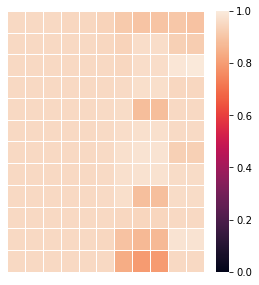

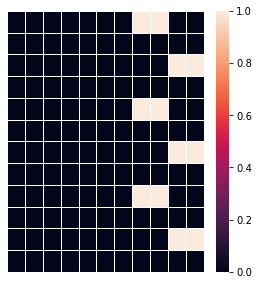

In [39]:
plt.figure(figsize = (norm_size * len(neighbors), norm_size * seq_len))
ax = sns.heatmap(probe_y_pd, linewidth=0.5, vmax = 1, vmin = 0)
plt.axis('off')
plt.show()

plt.figure(figsize = (norm_size * len(neighbors), norm_size * seq_len))
ax = sns.heatmap(X_probe[list(neighbors)], linewidth=0.5, vmax = 1, vmin = 0)
plt.axis('off')
plt.show()